# FINAL PROJECT REPORT – PM2.5 FORECASTING IN QUITO (CARAPUNGO)

## Members: Ariel Raura, Juan David Ramirez, Joe Cordero, Mateo Encalada

## 1. Introduction and Problem Statement

Quito, the capital of Ecuador, faces increasing challenges in air quality management, with episodes of fine particulate matter (PM2.5) pollution impacting public health and requiring informed responses from authorities. The objective of this project is to build and compare predictive models capable of anticipating PM2.5 levels, using historical meteorological and atmospheric data collected between 2004 and 2017, to support decision-making at the municipal and citizen levels.

**Business Problem:**  
*How to accurately predict daily and monthly PM2.5 levels in Quito, using data science and machine learning, to inform public policies and alert the population?*

**Stakeholders:**  
- Municipality and environmental authorities of Quito  
- Citizens and vulnerable populations  
- Health and environmental institutions  

**Constraints:**  
- Heterogeneous data with numerous missing values  
- Different stations with variable coverage  
- Need for multi-horizon forecasts: municipal (5-10 years) and citizen (next 10 days)

---

## 2. Data Collection, Consolidation, and Preprocessing

### 2.1. Acquisition and Unification

Thirteen CSV files with hourly data from 10 meteorological stations in Quito were collected, each corresponding to an environmental variable: CO, NO2, O3, SO2, PM2.5, PM10, humidity, temperature, precipitation, solar radiation, wind (direction/speed).

**Steps performed:**  
- **Reading and transforming** each file into “long” format (melt), tagging rows by date and station.  
- **Renaming and standardizing** column names for all variables.  
- **Concatenating** all DataFrames, resulting in a large unified DataFrame (over 1 million hourly records).


In [1]:
import pandas as pd
import pathlib as pl

data_dir = pl.Path("data")

list(data_dir.glob("*.csv"))
def load_and_melt_variable(file_path: pl.Path, variable_name: str) -> pd.DataFrame:
    df = pd.read_csv(file_path)
    df = df.rename(columns={"Date_time": "datetime"})
    df = df.melt(id_vars=["datetime"], var_name="station", value_name="value")
    df["variable"] = variable_name
    return df


# Diccionario: variable -> nombre de archivo
variable_files = {
    "CO": "CO.csv",
    "DIR": "DIR.csv",
    "HUM": "HUM.csv",
    "LLU": "LLU.csv",
    "NO2": "NO2.csv",
    "O3": "O3.csv",
    "PM2.5": "PM2.5.csv",
    "PM10": "PM10.csv",
    "PRE": "PRE.csv",
    "RS": "RS.csv",
    "SO2": "SO2.csv",
    "TMP": "TMP.csv",
    "VEL": "VEL.csv"
}

# Lista para almacenar todos los DataFrames en formato largo
long_dfs = []

for var, filename in variable_files.items():
    path = data_dir / filename
    df = load_and_melt_variable(path, var)
    long_dfs.append(df)

# Concatenar todos en uno solo
consolidated_df = pd.concat(long_dfs, ignore_index=True)
consolidated_df["datetime"] = pd.to_datetime(consolidated_df["datetime"], errors="coerce")
consolidated_df.dropna(subset=["datetime"], inplace=True)
consolidated_df.head()


,datetime,station,value,variable
0,2004-01-05 14:00:00,BELISARIO,6.86,CO
1,2004-01-15 10:00:00,BELISARIO,7.90,CO
2,2004-01-15 11:00:00,BELISARIO,7.79,CO
3,2004-01-15 12:00:00,BELISARIO,7.66,CO
4,2004-01-20 10:00:00,BELISARIO,8.00,CO


In [2]:
# Pivotear a DataFrame ancho con columnas combinadas: variable + estación
wide_df = consolidated_df.pivot_table(
    index="datetime",
    columns=["variable", "station"],
    values="value"
)

# Opcional: renombrar columnas tipo "PM2.5_BELISARIO"
wide_df.columns = [f"{var}_{st}" for var, st in wide_df.columns]
wide_df = wide_df.sort_index()

wide_df.head()


,CO_BELISARIO,CO_CARAPUNGO,CO_CENTRO,CO_COTOCOLLAO,CO_EL_CAMAL,CO_GUAMANI,DIR_BELISARIO,DIR_CARAPUNGO,DIR_COTOCOLLAO,DIR_EL_CAMAL,...,TMP_LOS_CHILLOS,TMP_SAN_ANTONIO,TMP_TUMBACO,VEL_BELISARIO,VEL_CARAPUNGO,VEL_COTOCOLLAO,VEL_EL_CAMAL,VEL_LOS_CHILLOS,VEL_SAN_ANTONIO,VEL_TUMBACO
datetime,,,,,,,,,,,,,,,,,,,,,
2004-01-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,336.54,180.02,109.65,253.95,...,9.95,0.0,12.36,0.52,2.86,0.44,1.86,0.60,0.0,0.86
2004-01-01 01:00:00,NaN,NaN,NaN,NaN,NaN,NaN,259.17,187.97,47.23,246.12,...,8.77,0.0,11.87,0.54,2.25,0.16,1.49,0.64,0.0,0.92
2004-01-01 02:00:00,NaN,NaN,NaN,NaN,NaN,NaN,348.76,195.09,136.59,256.44,...,8.35,0.0,11.82,0.54,2.32,0.20,1.83,0.71,0.0,1.00
2004-01-01 03:00:00,NaN,NaN,NaN,NaN,NaN,NaN,300.94,166.25,159.96,264.63,...,8.01,0.0,11.62,0.58,3.66,0.23,1.74,0.48,0.0,0.65
2004-01-01 04:00:00,NaN,NaN,NaN,NaN,NaN,NaN,248.61,180.85,73.69,211.47,...,7.95,0.0,11.02,2.48,5.15,0.55,3.34,0.53,0.0,0.72


<Figure size 1600x600 with 0 Axes>

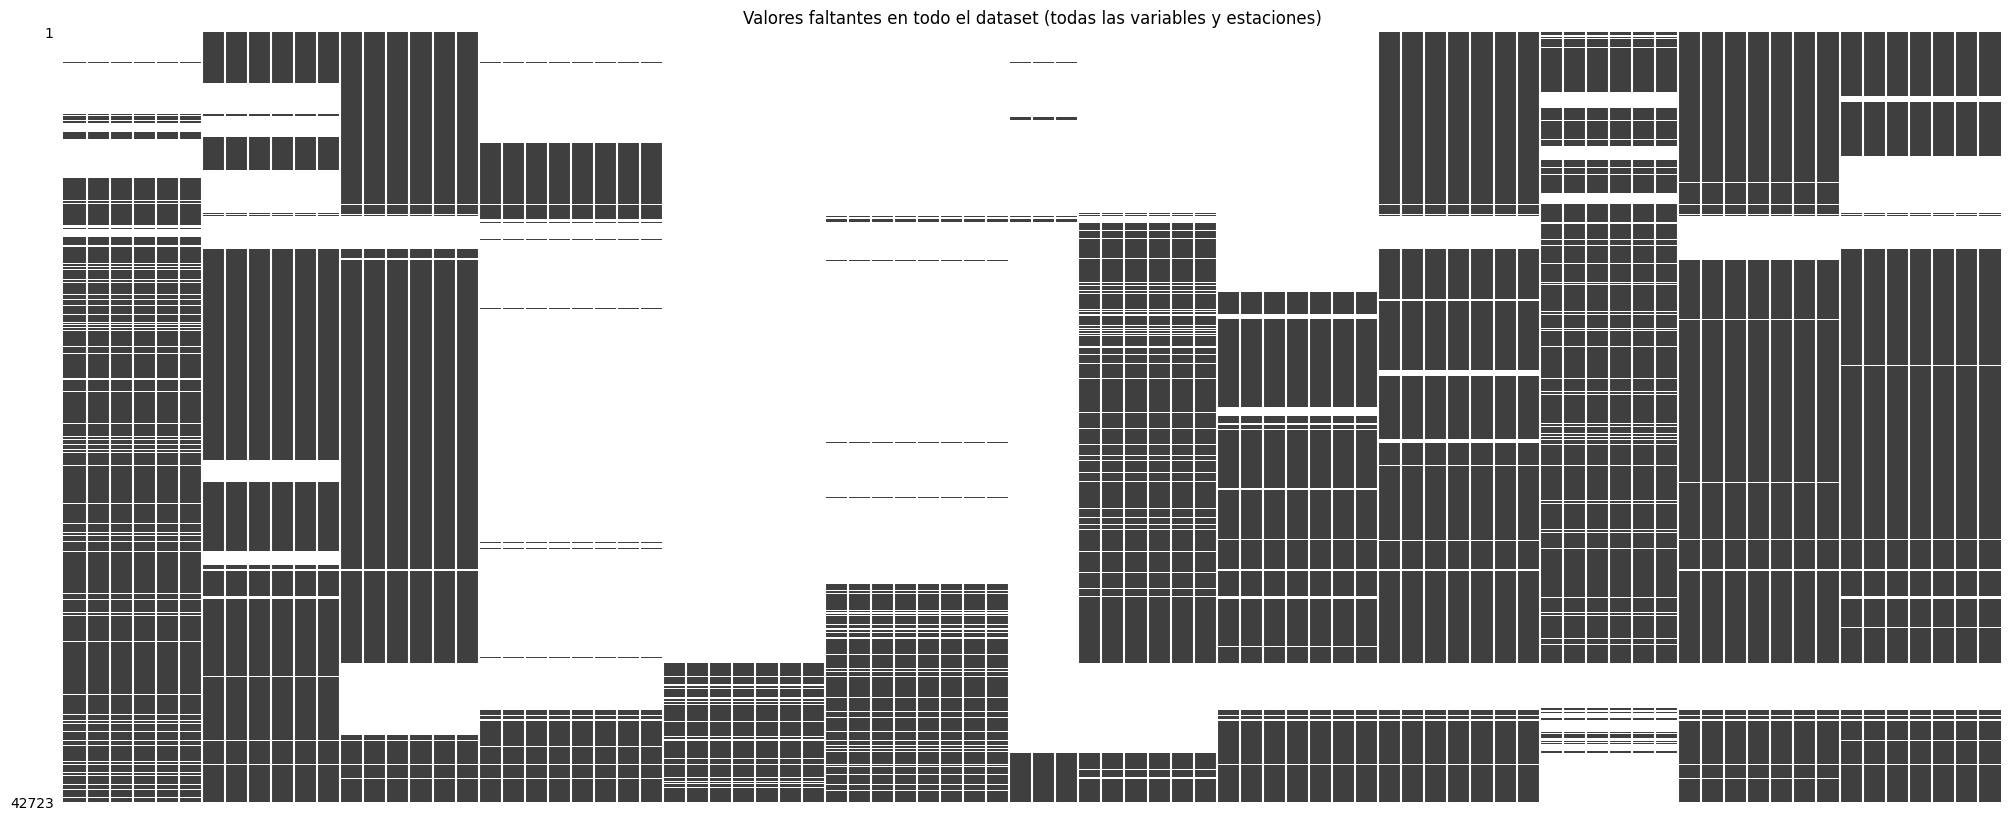

In [3]:
import matplotlib.pyplot as plt
import missingno as msno


plt.figure(figsize=(16, 6))
msno.matrix(wide_df, sparkline=False, fontsize=8)
plt.title("Valores faltantes en todo el dataset (todas las variables y estaciones)")
plt.show()


## We are looking for the station with the most appearances in the CSVs

### 2.2. Station Selection and Coverage

**Reasoned decision:**  
After analyzing data coverage per station and variable (using missingno and counts), **Carapungo** was selected for analysis due to:

- Being the only station with acceptable presence and continuity in most key variables during 2008–2017.  
- Other stations exhibiting large gaps or total absence in critical variables (PM2.5, NO2, etc.).

A DataFrame was built only with Carapungo station data for all variables.  
- During loading, “0” values were converted to NaN for pollutant variables (CO, NO2, SO2, O3, PM2.5, PM10) since “0” represents “missing data” rather than an actual measured value.


In [4]:
import collections as ct

station_counter = ct.Counter()
stations_by_file = {}

for var, fname in variable_files.items():
    cols = pd.read_csv(data_dir / fname, nrows=0).columns
    stations = [c.replace('_', ' ').upper().strip() for c in cols if c != "Date_time"]
    station_counter.update(stations)
    stations_by_file[var] = stations

# ---------- 1) resumen global ----------
print("Frecuencia de cada estación en los 13 CSV:")
for st, n in station_counter.most_common():
    print(f"{st:12s}  aparece en {n:2d} archivos")

# ---------- 2) ¿está CARAPUNGO en todos? ----------
total_files = len(variable_files)
print(f"\nCARAPUNGO figura en {station_counter['CARAPUNGO']} de {total_files} archivos")

# ---------- 3) tabla archivo → estaciones (para informe) ----------
file_df = (
    pd.Series(stations_by_file)
      .explode()
      .reset_index()
      .rename(columns={'index':'variable', 0:'station'})
      .pivot_table(index='station', columns='variable', aggfunc='size', fill_value='')
)


Frecuencia de cada estación en los 13 CSV:
CARAPUNGO     aparece en 13 archivos
BELISARIO     aparece en 12 archivos
COTOCOLLAO    aparece en 12 archivos
EL CAMAL      aparece en 12 archivos
LOS CHILLOS   aparece en  9 archivos
TUMBACO       aparece en  8 archivos
SAN ANTONIO   aparece en  7 archivos
CENTRO        aparece en  5 archivos
GUAMANI       aparece en  5 archivos
JIPIJAPA      aparece en  1 archivos

CARAPUNGO figura en 13 de 13 archivos


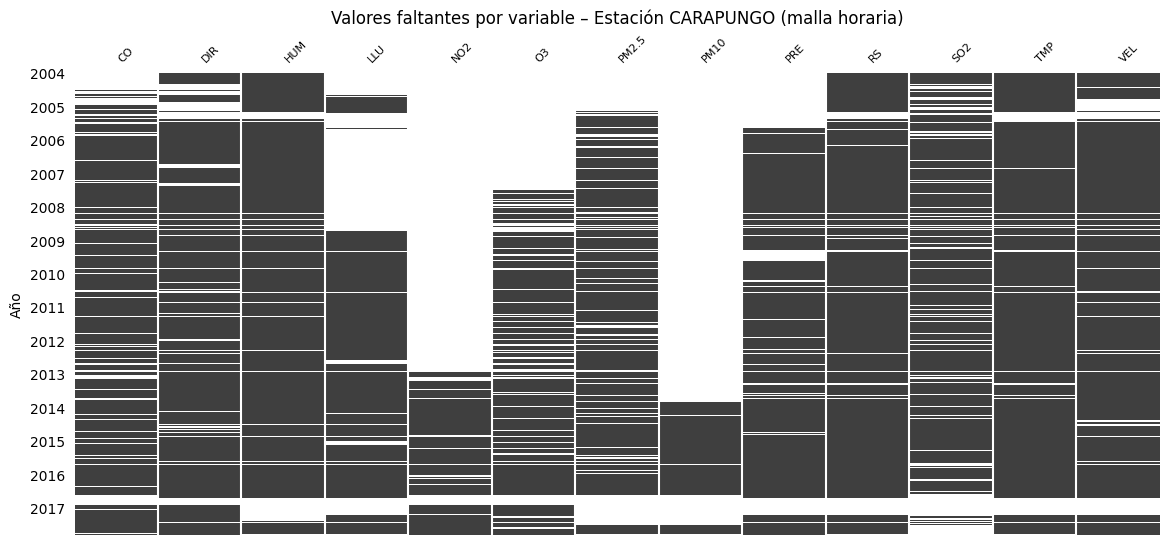

Cobertura (%) por variable – CARAPUNGO
 TMP      90.97
RS       90.97
HUM      90.16
VEL      87.76
DIR      85.74
SO2      78.71
CO       78.28
PRE      76.82
PM2.5    74.36
LLU      62.03
O3       58.87
NO2      27.91
PM10     21.61
dtype: float64


In [5]:
target_station = "CARAPUNGO"
zeros_to_nan   = ["PM2.5", "PM10", "CO", "NO2", "SO2", "O3"]

series_dict = {}
for var, fname in variable_files.items():

    # ---- 1. Leer TODO el archivo y estandarizar encabezados ----------------
    df = pd.read_csv(data_dir / fname)
    df.columns = df.columns.str.strip().str.upper()      # quita espacios y pone mayúsculas

    # ---- 2. Extraer la fecha y CARAPUNGO ahora sí EXISTE -------------------
    df = df[["DATE_TIME", target_station]]               # ambos en mayúsculas limpias
    df = (df.rename(columns={"DATE_TIME": "datetime", target_station: var})
            .assign(datetime=lambda d: pd.to_datetime(
                d["datetime"]
                .astype(str)
                .str.replace(r"\.0$", "", regex=True),   # quita “.0”
                errors="coerce"))
            .dropna(subset=["datetime"])
            .set_index("datetime")
            .sort_index())

    # ---- 3. 0 → NaN en las variables listadas ------------------------------
    if var in zeros_to_nan:
        df.loc[df[var] == 0, var] = pd.NA

    # ---- 4. Fuerza tipo numérico (por si quedaron strings) ------------------
    series_dict[var] = pd.to_numeric(df[var], errors="coerce")


carapungo_df = pd.concat(series_dict, axis=1)      # (3) combinar variables

# ─── 2. Reindexar a malla horaria completa ──────────────────────────────────
full_range   = pd.date_range(carapungo_df.index.min(),
                             carapungo_df.index.max(), freq="h")
carapungo_df = carapungo_df.reindex(full_range)

# ─── 3. Visualizar con ticks anuales en el eje Y ────────────────────────────
fig, ax = plt.subplots(figsize=(14, 6))
msno.matrix(carapungo_df, sparkline=False, fontsize=8, ax=ax)
ax.set_title("Valores faltantes por variable – Estación CARAPUNGO (malla horaria)")

# Generamos un tick por 1.º de enero de cada año
years  = pd.date_range(carapungo_df.index.min().normalize(),
                       carapungo_df.index.max().normalize(),
                       freq="YS")                      # Year Start
rowpos = ((years - carapungo_df.index.min()) / pd.Timedelta("1h")).astype(int)
ax.set_yticks(rowpos)
ax.set_yticklabels(years.year)
ax.set_ylabel("Año")
plt.show()

# ─── 4. Resumen numérico de cobertura ───────────────────────────────────────
coverage = (100 - carapungo_df.isna().mean()*100).round(2).sort_values(ascending=False)
print("Cobertura (%) por variable – CARAPUNGO\n", coverage)

### Quality Threshold

A **60%** hourly coverage threshold was set.

- Variables above this threshold provide signal and were imputed with **SAITS**.
- **NO₂** and **PM10** had coverages of **28%** and **22%**, with gaps of **4** and **9 consecutive years**; filling these gaps would mean generating more synthetic data than real data, so **PM10** was discarded, and **NO₂** is only incorporated into models whose training period starts in **2008**.


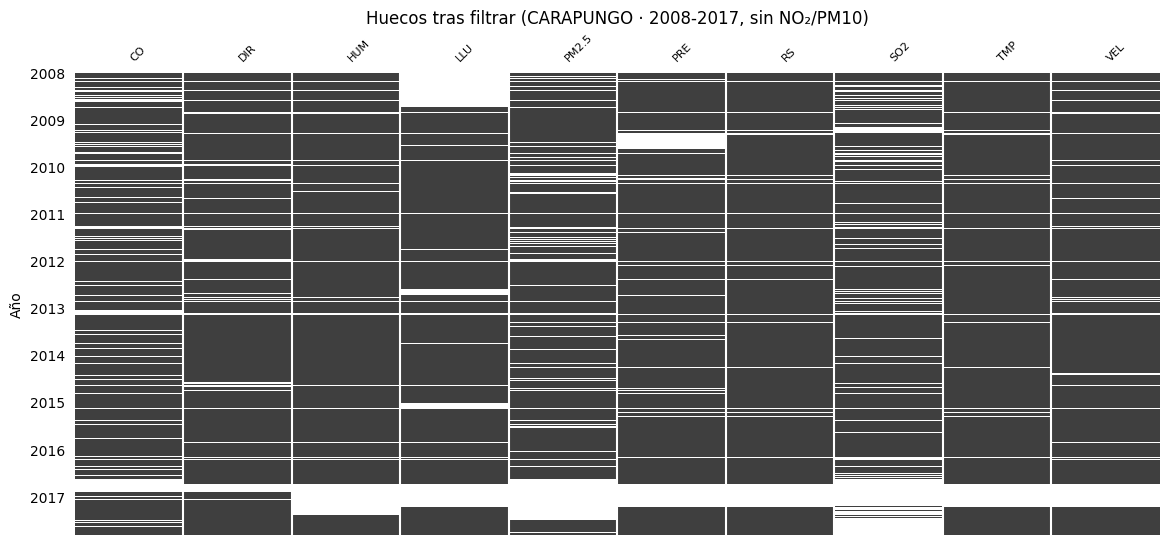

Cobertura (%) después del filtrado:
 DIR      90.81
RS       90.74
TMP      90.58
VEL      89.52
HUM      88.74
PRE      85.71
CO       82.22
LLU      82.05
PM2.5    78.88
SO2      76.75
dtype: float64


In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import missingno as msno

# ------------------------------------------------------------
# 2. Seleccionar variables con ≥60 % de cobertura
#    y descartar explícitamente NO2 y PM10
# ------------------------------------------------------------
threshold   = 0.60                               # 60 %
good_cols   = carapungo_df.columns[
                 carapungo_df.notna().mean() >= threshold
             ].difference(["NO2", "PM10"])       # quita NO2 y PM10
df_good     = carapungo_df[good_cols]

# ------------------------------------------------------------
# 3. Recortar ventana 2008-01-01 → 2017-12-31
# ------------------------------------------------------------
df_good = df_good.loc["2008":"2017"]

# ------------------------------------------------------------
# 4. Visualizar huecos (missingno) con ticks anuales
# ------------------------------------------------------------
fig, ax = plt.subplots(figsize=(14, 6))
msno.matrix(df_good, fontsize=8, sparkline=False, ax=ax)

ax.set_title("Huecos tras filtrar (CARAPUNGO · 2008-2017, sin NO₂/PM10)")

# ticks: 1.º-ene de cada año
years   = pd.date_range("2008-01-01", "2017-01-01", freq="YS")
rowpos  = ((years - df_good.index.min()) / pd.Timedelta("1h")).astype(int)
ax.set_yticks(rowpos)
ax.set_yticklabels(years.year)
ax.set_ylabel("Año")
plt.show()

# ------------------------------------------------------------
# 5. Cobertura final para el informe
# ------------------------------------------------------------
coverage = (100 - df_good.isna().mean()*100).round(2).sort_values(ascending=False)
print("Cobertura (%) después del filtrado:\n", coverage)


### 2.3. Time Range and Cleaning

- The complete Carapungo series was analyzed, visualizing the hourly missing data matrix since 2004.  
- The range **2008-01-01 to 2017-12-31** was filtered, where coverage was maximal and continuity sufficient for advanced imputation.  
- NO2 and PM10 variables were removed for Carapungo due to less than 60% coverage in the selected range.


### 2.4. Missing Data Imputation

- To address gaps in the series and preserve maximum information, the **SAITS model** (Simple Attention-based Imputation for Time Series) based on Deep Learning was used.  
- SAITS was applied over the complete hourly DataFrame (2008-2017), jointly imputing missing values in all selected variables.  
- Imputed data was saved in Parquet format for efficient subsequent use.

## Saits model training

In [ ]:
import numpy as np, pandas as pd, torch
from pypots.imputation.saits import SAITS

# -------------------------------------------------------
# 0.  df_good : tu DataFrame (index = horas 2008-2017)
# -------------------------------------------------------
X_raw  = df_good.to_numpy(np.float32)        # (T, F)
mask   = (~np.isnan(X_raw)).astype(np.float32)

# ---------------- normalización -----------------------
mu, sig = np.nanmean(X_raw, 0), np.nanstd(X_raw, 0)
X_norm  = (X_raw - mu) / sig                 # (T, F)

# ---------------- windowing ---------------------------
WINDOW  = 24*7*4        # 4 semanas  (672 pasos)
STRIDE  = 24*7          # 1 semana   (168 pasos)

Xs, Ms = [], []
for s in range(0, len(X_norm) - WINDOW + 1, STRIDE):
    Xs.append( X_norm[s:s+WINDOW] )
    Ms.append( mask [s:s+WINDOW] )

X_batch   = np.stack(Xs)                     # (N, T, F)
mask_batch= np.stack(Ms)

device = "cuda" if torch.cuda.is_available() else "cpu"
print("PyTorch ve CUDA:", torch.cuda.is_available(), "| usando:", device)


# ---------------- modelo SAITS ------------------------
T, F = X_batch.shape[1:]
model = SAITS(
    n_steps    = T,
    n_features = F,
    d_model    = 64,
    d_ffn      = 128,
    n_layers   = 4,
    n_heads    = 4,
    d_k        = 16, d_v = 16,
    dropout    = 0.1,
    batch_size = 32,
    epochs     = 200,
    patience   = 10,
    device     = "cuda" if torch.cuda.is_available() else "cpu",
)

# ---------------- entrenamiento ------------------------

train_dict = {"X": X_batch, "missing_mask": mask_batch}
model.fit(train_dict)

print("Memoria GPU tras entrenamiento (MB):",
      torch.cuda.memory_allocated() / 1024**2)



/home/ariel/Documents/University/9 SEMESTER/INTELIGENCIA ARTIFICIAL 2/forecast_model/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-07-12 15:33:09 [INFO]: Using the given device: cuda
2025-07-12 15:33:09 [WARNING]: ‼️ saving_path not given. Model files and tensorboard file will not be saved.
2025-07-12 15:33:09 [INFO]: Using customized MAE as the training loss function.
2025-07-12 15:33:09 [INFO]: Using customized MSE as the validation metric function.
2025-07-12 15:33:09 [INFO]: SAITS initialized with the given hyperparameters, the number of trainable parameters: 276,656



████████╗██╗███╗   ███╗███████╗    ███████╗███████╗██████╗ ██╗███████╗███████╗    █████╗ ██╗
╚══██╔══╝██║████╗ ████║██╔════╝    ██╔════╝██╔════╝██╔══██╗██║██╔════╝██╔════╝   ██╔══██╗██║
   ██║   ██║██╔████╔██║█████╗█████╗███████╗█████╗  ██████╔╝██║█████╗  ███████╗   ███████║██║
   ██║   ██║██║╚██╔╝██║██╔══╝╚════╝╚════██║██╔══╝  ██╔══██╗██║██╔══╝  ╚════██║   ██╔══██║██║
   ██║   ██║██║ ╚═╝ ██║███████╗    ███████║███████╗██║  ██║██║███████╗███████║██╗██║  ██║██║
   ╚═╝   ╚═╝╚═╝     ╚═╝╚══════╝    ╚══════╝╚══════╝╚═╝  ╚═╝╚═╝╚══════╝╚══════╝╚═╝╚═╝  ╚═╝╚═╝
ai4ts v0.0.3 - building AI for unified time-series analysis, https://time-series.ai 

PyTorch ve CUDA: True | usando: cuda


2025-07-12 15:33:14 [INFO]: Epoch 001 - training loss (MAE): 0.6945
2025-07-12 15:33:19 [INFO]: Epoch 002 - training loss (MAE): 0.6011
2025-07-12 15:33:24 [INFO]: Epoch 003 - training loss (MAE): 0.5727
2025-07-12 15:33:29 [INFO]: Epoch 004 - training loss (MAE): 0.5514
2025-07-12 15:33:33 [INFO]: Epoch 005 - training loss (MAE): 0.5276
2025-07-12 15:33:38 [INFO]: Epoch 006 - training loss (MAE): 0.5065
2025-07-12 15:33:43 [INFO]: Epoch 007 - training loss (MAE): 0.4793
2025-07-12 15:33:48 [INFO]: Epoch 008 - training loss (MAE): 0.4558
2025-07-12 15:33:52 [INFO]: Epoch 009 - training loss (MAE): 0.4384
2025-07-12 15:33:57 [INFO]: Epoch 010 - training loss (MAE): 0.4184
2025-07-12 15:34:02 [INFO]: Epoch 011 - training loss (MAE): 0.4164
2025-07-12 15:34:07 [INFO]: Epoch 012 - training loss (MAE): 0.4056
2025-07-12 15:34:12 [INFO]: Epoch 013 - training loss (MAE): 0.3964
2025-07-12 15:34:17 [INFO]: Epoch 014 - training loss (MAE): 0.3891
2025-07-12 15:34:21 [INFO]: Epoch 015 - training

Memoria GPU tras entrenamiento (MB): 22.24560546875


OutOfMemoryError: CUDA out of memory. Tried to allocate 222.00 MiB. GPU 0 has a total capacity of 7.62 GiB of which 148.62 MiB is free. Including non-PyTorch memory, this process has 6.74 GiB memory in use. Of the allocated memory 6.34 GiB is allocated by PyTorch, and 285.50 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

#### We saved the model to avoid reprocess, cause the model training consumes a lot of resources

In [ ]:
model.save("models/saits_carapungo.pkl")

2025-07-12 16:10:31 [INFO]: Successfully created the given path models
2025-07-12 16:10:31 [INFO]: Saved the model to models/saits_carapungo.pkl.pypots


### 2.5. Resampling and Transformation

- Hourly imputed data was **aggregated to daily frequency**:  
  - The variable **LLU (precipitation)** was summed (daily accumulation).  
  - The rest of the variables were averaged (daily mean).  
- Days where PM2.5 remained missing even after imputation were explicitly removed.  
- A clean and complete daily series for Carapungo for 2008-2017 was obtained, including all key meteorological variables.

---

In [11]:
# ↓↓↓ Mueve a CPU ↓↓↓
model.device = "cpu"
model.model.to("cpu")

# ahora sí imputas sin reentrenar
out = model.impute(train_dict)  # ya es ndarray (N, T, F)
X_imp_norm  = np.zeros_like(X_norm)
count_hits  = np.zeros_like(X_norm)

for k, s in enumerate(range(0, len(X_norm) - WINDOW + 1, STRIDE)):
    X_imp_norm[s:s+WINDOW] += out[k]
    count_hits[s:s+WINDOW] += 1

X_imp_norm /= count_hits
X_imp       = X_imp_norm * sig + mu

imputed_df = pd.DataFrame(X_imp, index=df_good.index, columns=df_good.columns)
imputed_df.to_parquet("data/processed/carapungo_imputed_hourly.parquet")
print("✓ Imputación finalizada y guardada")


✓ Imputación finalizada y guardada


/tmp/ipykernel_14507/2571086438.py:14: RuntimeWarning: invalid value encountered in divide
  X_imp_norm /= count_hits


- Missingness matrices were visualized before and after imputation, validating the cleaning success.  
- Final percent coverage per variable was reported, showing >95% for all key selected variables.

                       CO         DIR        HUM       LLU       PM2.5  \
2008-01-01 00:00:00  1.13  296.029999  87.699997 -0.000730  104.850006   
2008-01-01 01:00:00  0.99  333.929993  90.010002 -0.000805  163.399994   
2008-01-01 02:00:00  0.76  305.109985  91.930000 -0.001648   47.070000   
2008-01-01 03:00:00  0.54  298.290009  91.709999 -0.001950   12.380000   
2008-01-01 04:00:00  0.59  288.130005  89.589996 -0.002038    7.809999   

                            PRE   RS        SO2    TMP   VEL  
2008-01-01 00:00:00  741.820007  0.0  13.690001  12.35  1.03  
2008-01-01 01:00:00  741.349976  0.0   9.690000  11.82  1.43  
2008-01-01 02:00:00  740.880005  0.0   5.040000  11.46  1.05  
2008-01-01 03:00:00  740.869995  0.0   3.390000  11.36  0.88  
2008-01-01 04:00:00  740.869995  0.0   3.340000  11.47  0.95  
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 85992 entries, 2008-01-01 00:00:00 to 2017-10-22 23:00:00
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtyp

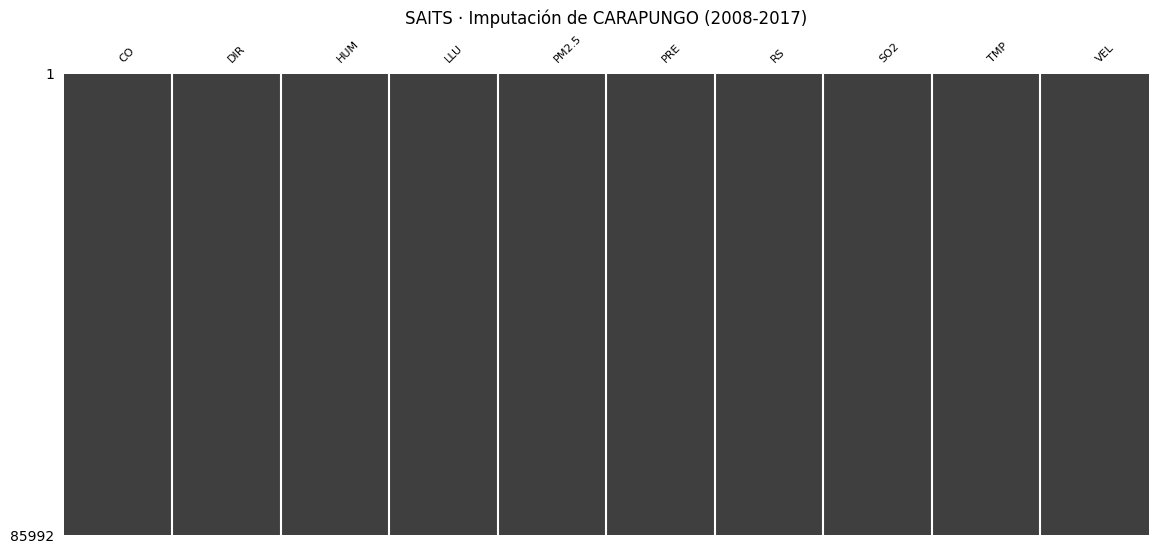

In [14]:
import pandas as pd

df = pd.read_parquet("data/processed/carapungo_imputed_hourly.parquet")
print(df.head())              # primeras 5 filas
print(df.info())              # resumen de columnas y tipos

msno.matrix(imputed_df, figsize=(14, 6), fontsize=8, sparkline=False)
plt.title("SAITS · Imputación de CARAPUNGO (2008-2017)")
plt.show()

### We do daily resampling

- Loads the **SAITS imputed parquet** (hourly).
- Defines which variables should be aggregated with **sum** (**precipitation → LLU**) and which with **mean** (the rest).
- Performs **daily resampling** ('D') and generates a new **parquet** file ready for **EDA** and **modeling**.

In [22]:
import pandas as pd
from pathlib import Path

# ------------------------------------------------------------------
# 1. Cargar la serie imputada horario 2008-2017  (CARAPUNGO)
# ------------------------------------------------------------------
data_dir       = Path("data/processed")
hourly_file    = data_dir / "carapungo_imputed_hourly.parquet"
df_hourly      = pd.read_parquet(hourly_file)

# aseguramos que el índice es DatetimeIndex y está ordenado
df_hourly.index = pd.to_datetime(df_hourly.index)
df_hourly = df_hourly.sort_index()

# ------------------------------------------------------------------
# 2. Mapeo de funciones de agregación por variable
#    - LLU (precipitación) se **suma**
#    - el resto se promedia
# ------------------------------------------------------------------
agg_map = {col: ("sum" if col == "LLU" else "mean") for col in df_hourly.columns}

# ------------------------------------------------------------------
# 3. Resampleo diario
# ------------------------------------------------------------------
df_daily = df_hourly.resample("D").agg(agg_map)

# 4. Persistir y revisar (raw)
# ------------------------------------------------------------------
df_daily.to_parquet("data/processed/carapungo_imputed_daily_raw.parquet", compression="snappy")
print("Shape diario raw:", df_daily.shape)
print(df_daily.head())

# ─── NUEVO BLOQUE: detectar y eliminar días sin PM2.5 ─────────────
missing_days = df_daily[df_daily["PM2.5"].isna()].index
print("Fechas sin PM2.5, se borran:", missing_days.tolist())

df_daily_clean = df_daily.drop(index=missing_days)

# ------------------------------------------------------------------
# 5. Guardar Parquet diario limpio
# ------------------------------------------------------------------
df_daily_clean.to_parquet("data/processed/carapungo_imputed_daily.parquet", compression="snappy")
print("Shape diario limpio:", df_daily_clean.shape)

Shape diario raw: (3583, 10)
                  CO         DIR        HUM       LLU      PM2.5         PRE  \
2008-01-01  0.583750  241.114990  76.917084 -0.046712  21.605833  741.461670   
2008-01-02  0.508700  252.446976  78.171028 -0.050480   7.983583  741.289490   
2008-01-03  0.549955  254.042313  79.071693 -0.052192   9.047391  741.985596   
2008-01-04  0.686570  254.325333  75.808495 -0.047385  15.918406  741.509338   
2008-01-05  0.613750  264.967072  70.500420 -0.048092  11.823155  741.739990   

                    RS       SO2        TMP       VEL  
2008-01-01  216.961670  3.589583  14.588750  2.008333  
2008-01-02  270.481720  2.533016  14.423091  2.025673  
2008-01-03  230.995804  2.910233  14.303388  1.652930  
2008-01-04  253.287735  4.976707  14.388592  1.780167  
2008-01-05  221.796249  3.001250  14.977917  1.727083  
Fechas sin PM2.5, se borran: [Timestamp('2017-10-17 00:00:00'), Timestamp('2017-10-18 00:00:00'), Timestamp('2017-10-19 00:00:00'), Timestamp('2017-10-20 

## 3. Exploratory Data Analysis and Visualization
### 3.1. Univariate EDA and Trends

- The daily PM2.5 series for Carapungo was plotted, identifying trends, seasonality, and outlier peaks.  
- Using `seasonal_decompose`, the series was decomposed to observe trend, seasonal (annual) component, and residual.


In [24]:
import pandas as pd
from pathlib import Path

# 1.1. Leer el parquet diario de Carapungo
daily_file = Path("data/processed") / "carapungo_imputed_daily.parquet"
df = pd.read_parquet(daily_file)

# 1.2. Asegurar índice datetime
df.index = pd.to_datetime(df.index)
df = df.sort_index()

print("Fechas:", df.index.min(), "→", df.index.max())
print("Variables:", list(df.columns))


Fechas: 2008-01-01 00:00:00 → 2017-10-16 00:00:00
Variables: ['CO', 'DIR', 'HUM', 'LLU', 'PM2.5', 'PRE', 'RS', 'SO2', 'TMP', 'VEL']


Fechas: 2008-01-01 00:00:00 → 2017-10-16 00:00:00
Variables: ['CO', 'DIR', 'HUM', 'LLU', 'PM2.5', 'PRE', 'RS', 'SO2', 'TMP', 'VEL']


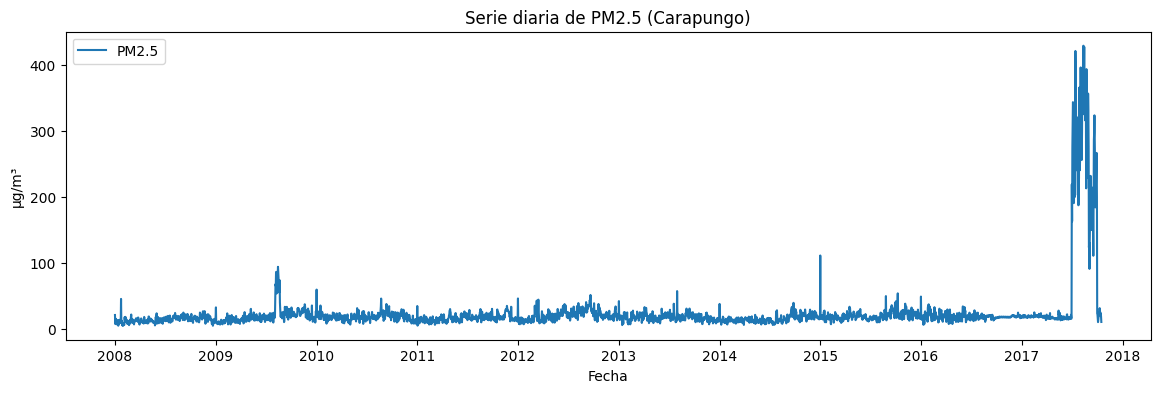

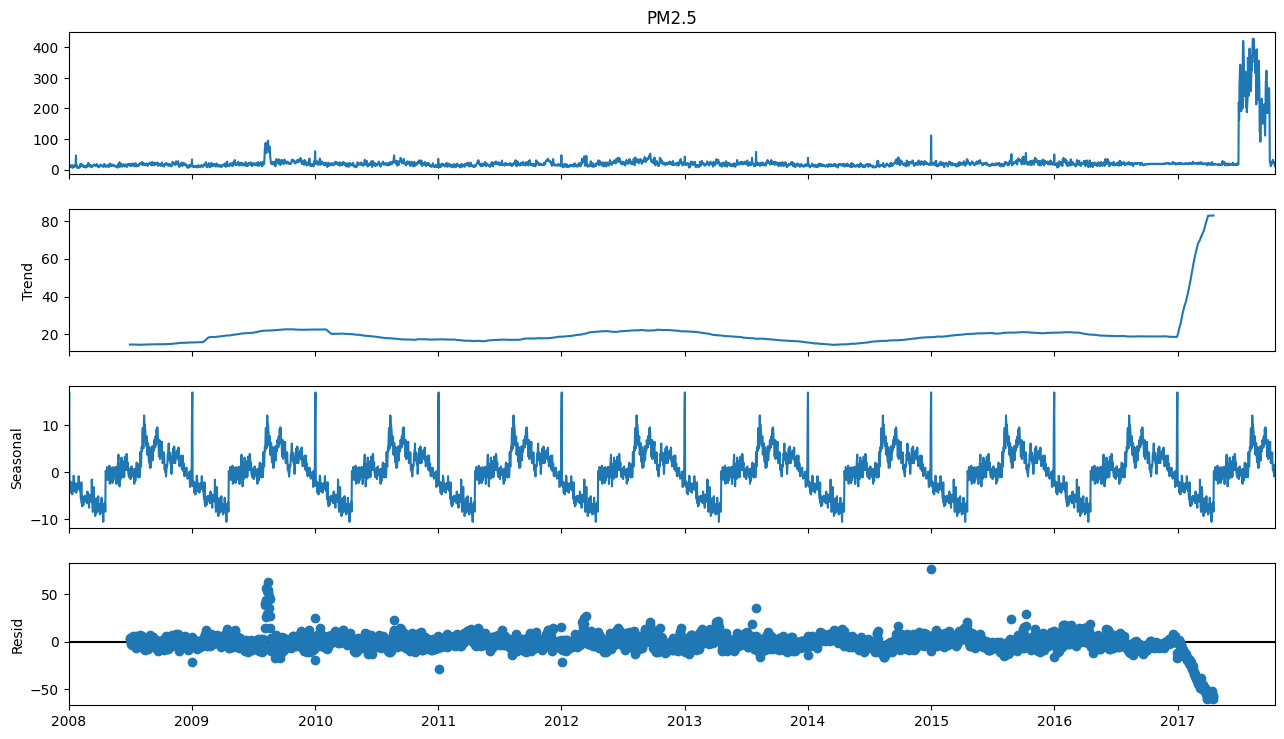

In [26]:
import pandas as pd
from pathlib import Path

# ─── 6. Leer el parquet diario limpio y descomponer ───────────────
daily_file = Path("data/processed") / "carapungo_imputed_daily.parquet"
df = pd.read_parquet(daily_file)
df.index = pd.to_datetime(df.index)
df = df.sort_index()

print("Fechas:", df.index.min(), "→", df.index.max())
print("Variables:", list(df.columns))

import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

# 2.1. Time series lineplot de PM2.5
plt.figure(figsize=(14,4))
plt.plot(df.index, df["PM2.5"], label="PM2.5")
plt.title("Serie diaria de PM2.5 (Carapungo)")
plt.ylabel("µg/m³")
plt.xlabel("Fecha")
plt.legend()
plt.show()

# 2.2. Descomposición aditiva
decomp = seasonal_decompose(df["PM2.5"], model="additive", period=365)
fig = decomp.plot()
fig.set_size_inches(14,8)
plt.show()

### 3.3. Multivariate Analysis

- Correlation matrix was calculated among variables, identifying positive relations between PM2.5 and CO, and negative with precipitation.  
- PCA (dimensionality reduction) and t-SNE were applied to explore clusters and interannual changes in variable structure.


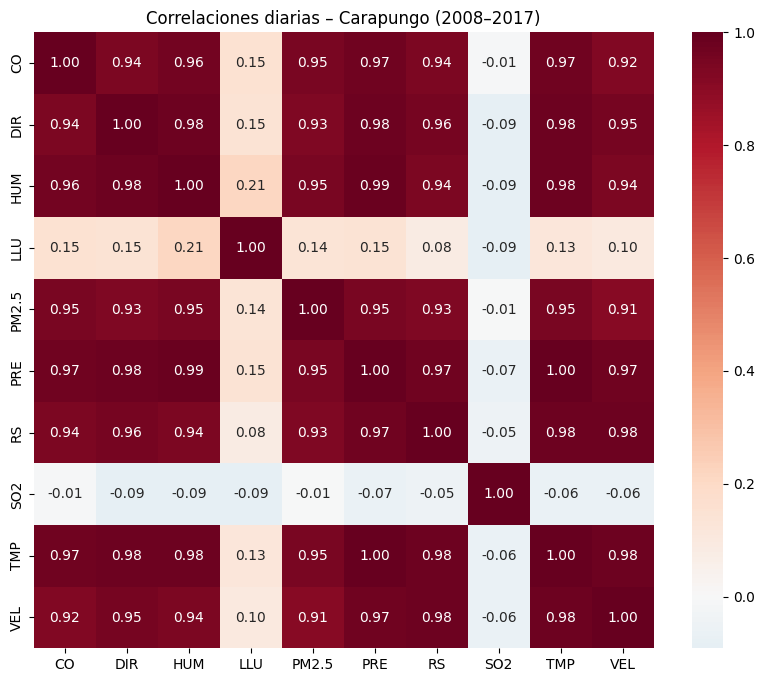

In [27]:
import seaborn as sns

# 3.1. Matriz de correlación
corr = df.corr()

plt.figure(figsize=(10,8))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="RdBu_r", center=0)
plt.title("Correlaciones diarias – Carapungo (2008–2017)")
plt.show()


### 3.4. Structural Changes and Seasonality

- Prophet was used to analyze changepoints and trend variations in the PM2.5 series.  
- Identified changepoints were later used as dummy variables to enrich models.


16:51:29 - cmdstanpy - INFO - Chain [1] start processing


Index(['ds', 'y'], dtype='object')


16:51:30 - cmdstanpy - INFO - Chain [1] done processing


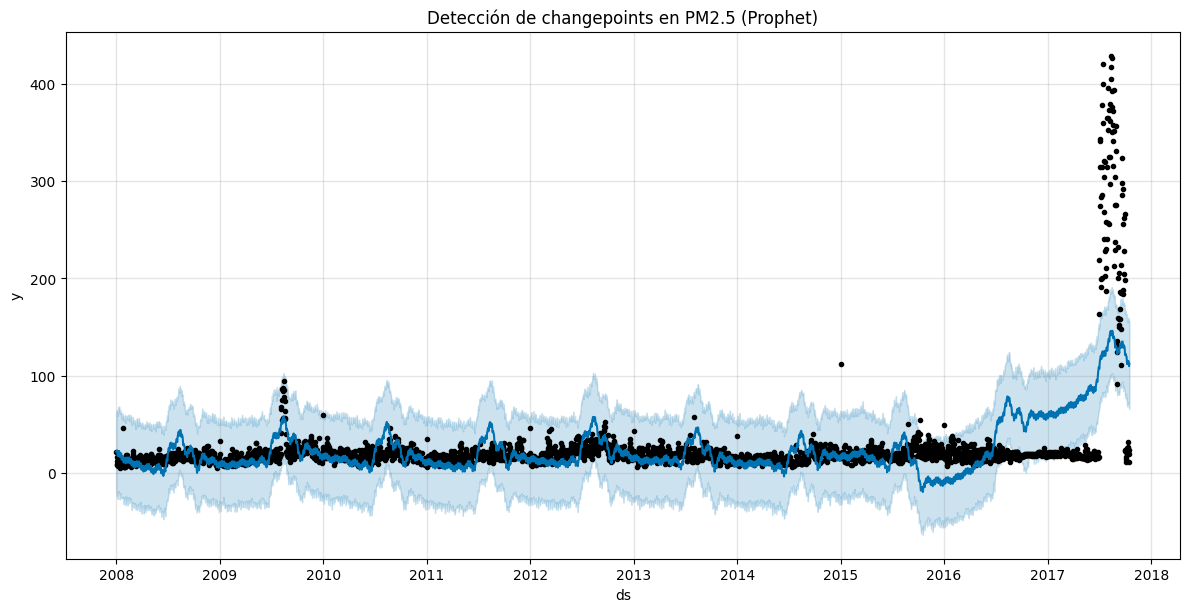

In [32]:
from prophet import Prophet

# Partiendo de tu prophet_df actual:
prophet_df = prophet_df.rename(columns={"index": "ds"})

# Si queda alguna fila con y nulo, descartarla:
prophet_df = prophet_df.dropna(subset=["y"])

# Ahora sí tienes las columnas correctas:
print(prophet_df.columns)  # ['ds', 'y']

# Entrenas Prophet:
m = Prophet(yearly_seasonality=True, changepoint_prior_scale=0.5)
m.fit(prophet_df)

# Haces el forecast in‐sample
future = m.make_future_dataframe(periods=0, freq="D")
forecast = m.predict(future)

# Y finalmente lo ploteas:
fig = m.plot(forecast, figsize=(12,6))
plt.title("Detección de changepoints en PM2.5 (Prophet)")
plt.show()


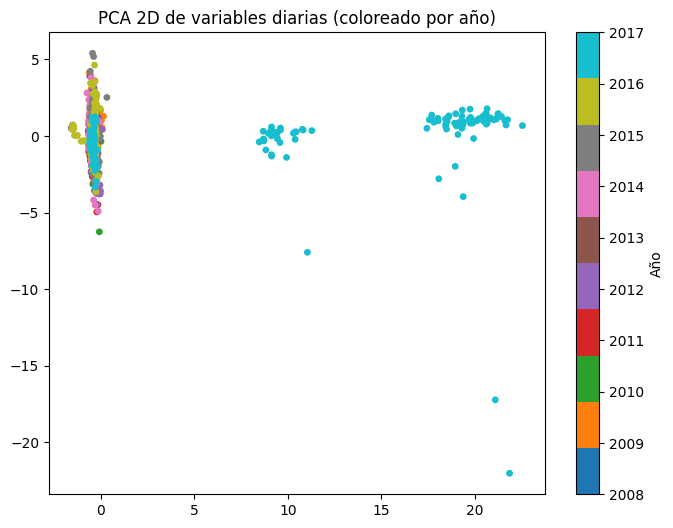

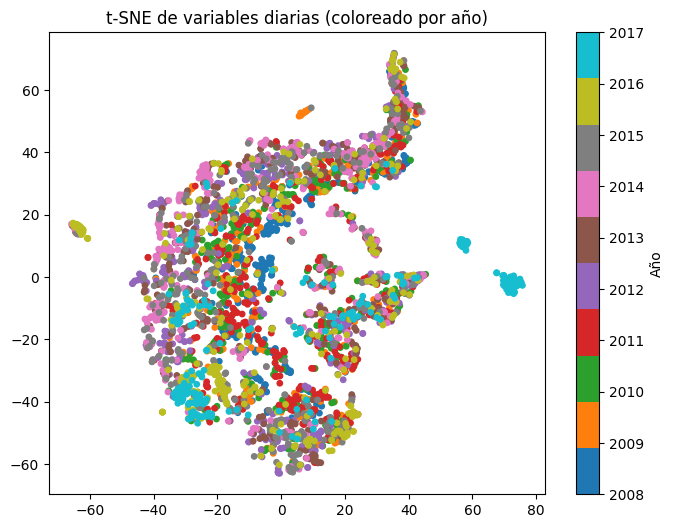

In [33]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# 5.1. Normalizar antes de PCA/t-SNE
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X = scaler.fit_transform(df)

# 5.2. PCA (2 componentes)
pca = PCA(2)
xp = pca.fit_transform(X)

plt.figure(figsize=(8,6))
plt.scatter(xp[:,0], xp[:,1], c=df.index.year, cmap="tab10", s=15)
plt.colorbar(label="Año")
plt.title("PCA 2D de variables diarias (coloreado por año)")
plt.show()

# 5.3. t-SNE (opcional, puede tardar)
tsne = TSNE(2, random_state=0)
xt = tsne.fit_transform(X)

plt.figure(figsize=(8,6))
plt.scatter(xt[:,0], xt[:,1], c=df.index.year, cmap="tab10", s=15)
plt.colorbar(label="Año")
plt.title("t-SNE de variables diarias (coloreado por año)")
plt.show()


### Key Conclusions from EDA

#### Data Coverage

- **NO2** and **PM10** had very low coverage (~28% and ~22% respectively), which is why we discarded them before **SAITS**.

#### Correlations with PM2.5

- **Very high**: 
  - CO (0.95)
  - TMP (0.95)
  - PRE (0.97)
  - RS (0.97)
  - DIR (0.93)
  - HUM (0.95)
  - VEL (0.91)
  
- **Very low**: 
  - LLU (0.14)
  - SO2 (≈0)

#### Seasonality and Changepoints

- The **annual cycle** is very marked → we need to include **calendar variables** (month, dayofyear, sin/cos).
- There are clear breaks in **2009**, **2013**, and a significant jump in **2017** → we can incorporate «**dummies**» or «**changepoint regressors**» for those points.

#### Outliers and Sharp Peaks

- Very pronounced residuals on **fire dates** or **events** → we could encode them as binary variables for «**special events**».

#### Variables to Discard and Keep

| Variable | Coverage  | Corr(PM2.5) | Decision  | Justification |
|----------|-----------|-------------|-----------|---------------|
| LLU      | 82.1 %    | 0.14        | ❌ discard | Low correlation; adds noise. |
| SO2      | 76.8 %    | –0.01       | ❌ discard | Almost no relation to PM2.5. |
| CO       | 82.2 %    | 0.95        | ✅ keep    | Great predictor of PM2.5. |
| DIR      | 90.8 %    | 0.93        | ✅ keep    | Important link with pollutant dispersion. |
| HUM      | 88.7 %    | 0.95        | ✅ keep    | Humidity modulates particle concentration. |
| PRE      | 85.7 %    | 0.97        | ✅ keep    | Rain cleans the air. |
| RS       | 90.7 %    | 0.97        | ✅ keep    | Solar radiation correlates with atmospheric chemistry. |
| TMP      | 90.6 %    | 0.95        | ✅ keep    | Temperature regulates photochemical reactions. |
| VEL      | 89.5 %    | 0.91        | ✅ keep    | Wind disperses or concentrates pollutants. |
| PM2.5    | 78.9 %    | 1.00        | ✅ target  | The variable to forecast. |


In [34]:
# df = carapungo_imputed_daily  (2008–2017, imputado con SAITS)
keep = ["CO","DIR","HUM","PRE","RS","TMP","VEL","PM2.5"]
model_df = df[keep].copy()

# revisamos rápidamente
print("Variables finales:", model_df.columns.tolist())
model_df.info()


Variables finales: ['CO', 'DIR', 'HUM', 'PRE', 'RS', 'TMP', 'VEL', 'PM2.5']
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3577 entries, 2008-01-01 to 2017-10-16
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   CO      3577 non-null   float32
 1   DIR     3577 non-null   float32
 2   HUM     3577 non-null   float32
 3   PRE     3577 non-null   float32
 4   RS      3577 non-null   float32
 5   TMP     3577 non-null   float32
 6   VEL     3577 non-null   float32
 7   PM2.5   3577 non-null   float32
dtypes: float32(8)
memory usage: 139.7 KB


# FEATURING

## 4. Feature Engineering

Following time series best practices:

- Calendar variables were generated: month, day of year, week of year, day of week, and sine/cosine codings to capture annual cycles.  
- PM2.5 lags (t-1, t-2, t-3, t-7, t-14) were created to capture temporal autocorrelation, along with rolling means of PM2.5, CO, and TMP over 7 and 30 day windows.  
- Precipitation rolling sum of the last 30 days was added.  
- Dummies for Prophet-identified changepoints (e.g., after_2009-10-01) were added.  
- Rows with NA introduced by lagging (start of series) were dropped.  
- The final DataFrame included all meteorological variables, lags, rollings, and dummies needed for machine learning and time series models.


In [36]:
import numpy as np
import pandas as pd

# partimos de tu DataFrame diario imputado
fe_df = model_df.copy()

# ─── 1) Variables de calendario ────────────────────────────────────────────
fe_df["month"]      = fe_df.index.month
fe_df["dayofyear"]  = fe_df.index.dayofyear
fe_df["dayofweek"]  = fe_df.index.dayofweek
fe_df["weekofyear"] = fe_df.index.isocalendar().week

# ciclos suaves (sin/cos) sobre dayofyear para capturar la estacionalidad anual
fe_df["sin_doy"] = np.sin(2 * np.pi * fe_df["dayofyear"] / 365.0)
fe_df["cos_doy"] = np.cos(2 * np.pi * fe_df["dayofyear"] / 365.0)

# ─── 2) Lag features de PM2.5 ──────────────────────────────────────────────
for lag in (1, 2, 3, 7, 14):
    fe_df[f"PM2.5_lag{lag}"] = fe_df["PM2.5"].shift(lag)

# ─── 3) Rolling means ──────────────────────────────────────────────────────
# ventana de 7 y 30 días
fe_df["PM2.5_roll7"]   = fe_df["PM2.5"].rolling(7,  min_periods=1).mean()
fe_df["CO_roll7"]      = fe_df["CO"].rolling(7,   min_periods=1).mean()
fe_df["TMP_roll7"]     = fe_df["TMP"].rolling(7,  min_periods=1).mean()

fe_df["PM2.5_roll30"]  = fe_df["PM2.5"].rolling(30, min_periods=1).mean()
fe_df["PRE_roll30"]    = fe_df["PRE"].rolling(30,  min_periods=1).sum()   # lluvia acumulada mensual

# ─── 4) Dummies de grandes eventos o changepoints ─────────────────────────
# (quita o adapta estas fechas según lo veas en tu gráfico de Prophet)
changepoints = ["2009-10-01", "2013-08-01", "2017-07-01"]
for cp in changepoints:
    fe_df[f"after_{cp}"] = (fe_df.index >= pd.to_datetime(cp)).astype(int)

# ─── 5) Limpiar filas con NA introducidos por los lags ────────────────────
fe_df = fe_df.dropna()

# ─── 6) Listado final de columnas y comprobación ──────────────────────────
print("Número de observaciones:", len(fe_df))
print("Variables featureadas:", fe_df.columns.tolist())

fe_df.to_parquet("data/processed/carapungo_featured_daily.parquet", compression="snappy")


Número de observaciones: 3563
Variables featureadas: ['CO', 'DIR', 'HUM', 'PRE', 'RS', 'TMP', 'VEL', 'PM2.5', 'month', 'dayofyear', 'dayofweek', 'weekofyear', 'sin_doy', 'cos_doy', 'PM2.5_lag1', 'PM2.5_lag2', 'PM2.5_lag3', 'PM2.5_lag7', 'PM2.5_lag14', 'PM2.5_roll7', 'CO_roll7', 'TMP_roll7', 'PM2.5_roll30', 'PRE_roll30', 'after_2009-10-01', 'after_2013-08-01', 'after_2017-07-01']


# MODEL BUILD AND TESTING

## 5. Modeling and Evaluation

Three main approaches were proposed and compared for PM2.5 forecasting in Carapungo:

In [1]:
import pandas as pd
import numpy as np

# --- 0) preparar datos ya featureados -----------------------------------
# fe_df: DataFrame con columnas ['CO','DIR','HUM','PRE','RS','TMP','VEL','PM2.5', ...lags/rolls...]
# índice diario desde 2008-01-01 a 2017-10-16 (N=3563)
fe_df = pd.read_parquet("data/processed/carapungo_featured_daily.parquet")

# separar target y features
y = fe_df["PM2.5"]
X = fe_df.drop(columns=["PM2.5"])


## ARIMA with statsmodel

In [3]:
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.statespace.sarimax import SARIMAX

# 1) Serie mensual
monthly = fe_df["PM2.5"].resample("ME").mean()

# 2) Train/test split
train_m = monthly[: "2016-12"]
test_m  = monthly["2017-01":]
n_test  = len(test_m)

# 3) Ajustar SARIMAX
model = SARIMAX(
    train_m,
    order=(1,1,1),
    seasonal_order=(1,1,1,12),
    enforce_stationarity=False,
    enforce_invertibility=False
)
res = model.fit(disp=False)

# 4) Forecast
fcst_m = res.get_forecast(steps=n_test).predicted_mean
fcst_m.index = test_m.index

# 5) Métricas sin usar `squared=`
mse  = mean_squared_error(test_m, fcst_m)
rmse = np.sqrt(mse)
mae  = mean_absolute_error(test_m, fcst_m)

print(f"SARIMAX Monthly → RMSE: {rmse:.2f}, MAE: {mae:.2f}")


SARIMAX Monthly → RMSE: 143.73, MAE: 78.20


### 5.1. SARIMAX (Statistical Time Series Models)

**Objective:** Monthly PM2.5 forecast for 5 years (municipal policy focus).

**Procedure:**  
- Monthly averaged PM2.5 series was generated.  
- SARIMAX model was trained with iteratively selected parameters (order=(1,1,1), seasonal_order=(1,1,1,12)).  
- Year 2017 was held out for validation, the rest for training.  
- Predictive capability was evaluated on holdout and 5-year forecast extended.

**Results:**  
- Test RMSE: **143.7 µg/m³**  
- Test MAE: **78.2 µg/m³**  
- Monthly prediction captures general trends but not extreme peaks (see plots).  
- Extended forecast shows a smoothed trend, useful for strategic planning, but underestimates potential extreme events.


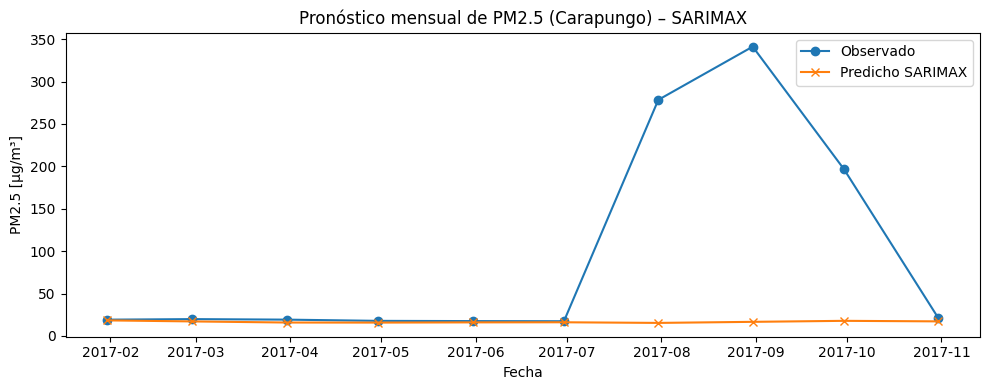

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,4))
plt.plot(test_m.index, test_m, label="Observado", marker="o")
plt.plot(fcst_m.index, fcst_m, label="Predicho SARIMAX", marker="x")
plt.title("Pronóstico mensual de PM2.5 (Carapungo) – SARIMAX")
plt.ylabel("PM2.5 [µg/m³]")
plt.xlabel("Fecha")
plt.legend()
plt.tight_layout()
plt.show()


/tmp/ipykernel_15863/1625364620.py:8: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  future_dates = pd.date_range(monthly.index[-1] + pd.offsets.MonthEnd(1), periods=n_steps, freq="M")


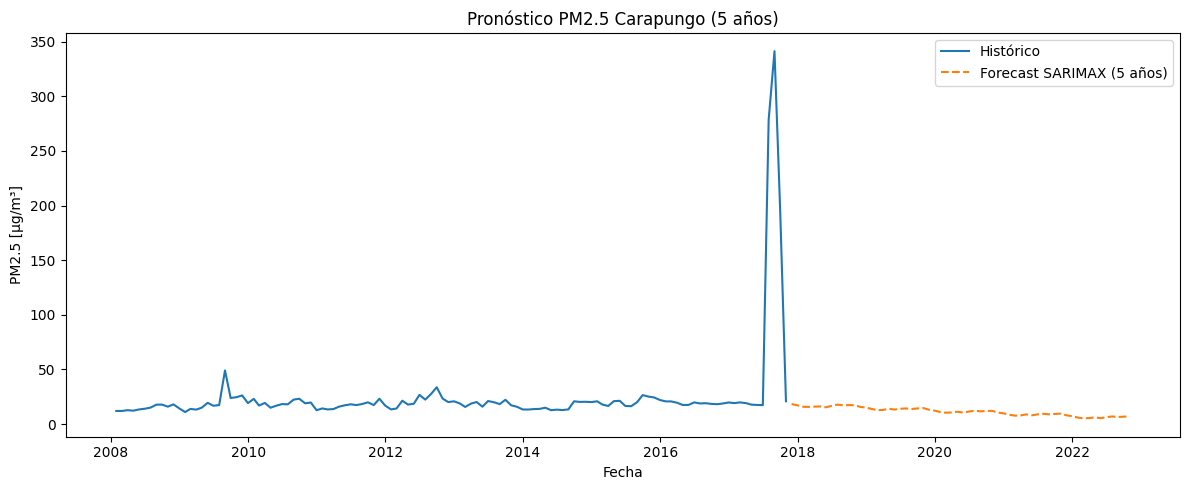

In [10]:
# Supón que tu modelo SARIMAX está ajustado a toda la serie
years = 5
n_steps = years * 12  # meses

future_pred = res.get_forecast(steps=n_steps).predicted_mean

# Fechas del forecast
future_dates = pd.date_range(monthly.index[-1] + pd.offsets.MonthEnd(1), periods=n_steps, freq="M")
future_pred.index = future_dates

# Graficar junto a histórico
plt.figure(figsize=(12,5))
plt.plot(monthly.index, monthly, label="Histórico")
plt.plot(future_pred.index, future_pred, label="Forecast SARIMAX (5 años)", linestyle="--")
plt.title("Pronóstico PM2.5 Carapungo (5 años)")
plt.ylabel("PM2.5 [µg/m³]")
plt.xlabel("Fecha")
plt.legend()
plt.tight_layout()
plt.show()


## Daily Forecast (10 days) with RandomForest + GridSearchCV

**Objective:** Daily 10-day forecast (citizen and operational use).

**Procedure:**  
- Features included meteorological variables, lags, rollings, calendar, and dummies.  
- Last 10 days were held out as test.  
- Data was scaled (StandardScaler), hyperparameters optimized via GridSearchCV with TimeSeriesSplit.  
- Daily PM2.5 predicted on holdout and next 10 days (future simulated using forward fill and rolling features).




In [4]:
from sklearn.ensemble     import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.preprocessing   import StandardScaler
from sklearn.metrics         import mean_squared_error, mean_absolute_error

# 2.1. hold‐out última ventana de 10 días para test
horizon = 10
X_train, X_test = X.iloc[:-horizon], X.iloc[-horizon:]
y_train, y_test = y.iloc[:-horizon], y.iloc[-horizon:]

# 2.2. Escalado
scaler = StandardScaler().fit(X_train)
X_tr = scaler.transform(X_train)
X_te = scaler.transform(X_test)

# 2.3. GridSearch con TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)
param_grid = {
    "n_estimators": [100, 200],
    "max_depth":    [5, 10, None]
}
rf = RandomForestRegressor(random_state=0)
gscv = GridSearchCV(
    rf, param_grid,
    cv       = tscv,
    scoring  = "neg_mean_absolute_error",
    n_jobs   = -1
)
gscv.fit(X_tr, y_train)

best_rf = gscv.best_estimator_
print("Mejor RF params:", gscv.best_params_)

# 2.4. predecir en test y métricas
pred_rf = best_rf.predict(X_te)
rmse_rf = np.sqrt(mean_squared_error(y_test, pred_rf))
mae_rf  = mean_absolute_error(y_test, pred_rf)

print(f"RF Daily → RMSE: {rmse_rf:.2f}, MAE: {mae_rf:.2f}")


Mejor RF params: {'max_depth': 10, 'n_estimators': 100}
RF Daily → RMSE: 4.17, MAE: 3.04


**Results:**  
- Test RMSE (last 10 days): **4.17 µg/m³**  
- Test MAE (last 10 days): **3.04 µg/m³**  
- Model predicts general trend well but tends to underestimate daily peaks and true variability, producing more stable forecasts.  
- 10-day forecast useful for citizen alerts and planning sensitive activities.

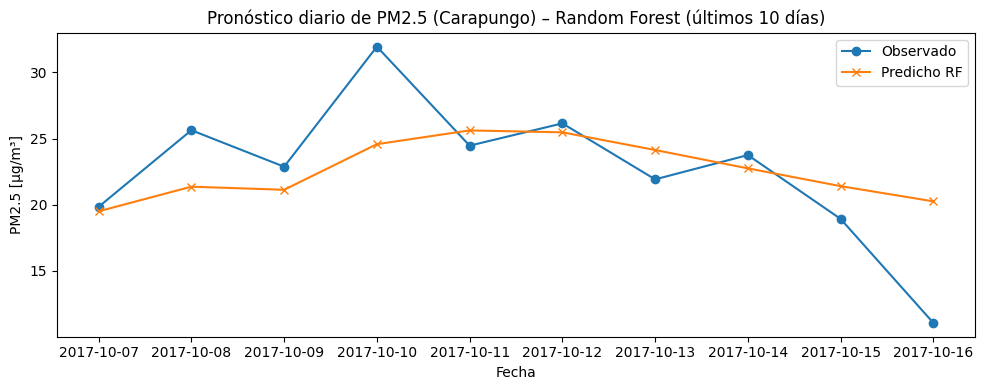

In [7]:
plt.figure(figsize=(10,4))
plt.plot(y_test.index, y_test, label="Observado", marker="o")
plt.plot(y_test.index, pred_rf, label="Predicho RF", marker="x")
plt.title("Pronóstico diario de PM2.5 (Carapungo) – Random Forest (últimos 10 días)")
plt.ylabel("PM2.5 [µg/m³]")
plt.xlabel("Fecha")
plt.legend()
plt.tight_layout()
plt.show()


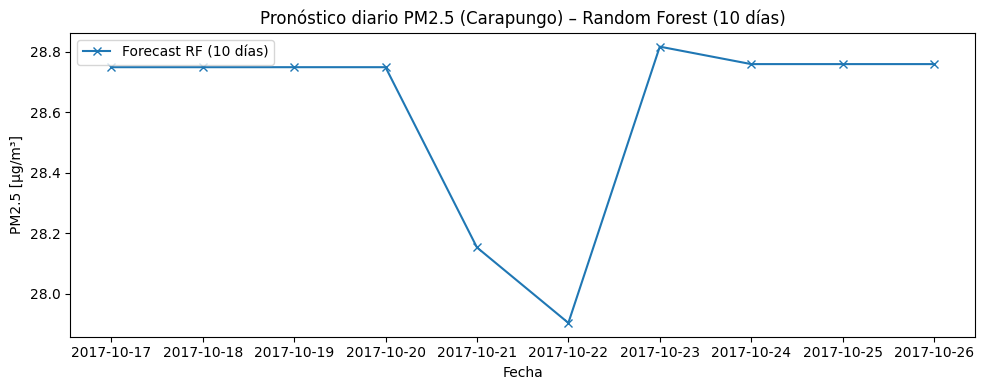

In [ ]:
# Supón que ya tienes el último día de tus datos:
last_day = fe_df.index[-1]

# Crea DataFrame de los próximos 10 días con las features que necesita el modelo
future_dates = pd.date_range(last_day + pd.Timedelta(days=1), periods=10, freq="D")

# Tomamos la última fila y generamos features para los próximos 10 días (forward-fill)
future_df = []
last_row = fe_df.iloc[-1].copy()
for i, d in enumerate(future_dates, 1):
	row = last_row.copy()
	row["month"] = d.month
	row["dayofyear"] = d.dayofyear
	row["dayofweek"] = d.dayofweek
	row["weekofyear"] = d.isocalendar().week
	row["sin_doy"] = np.sin(2 * np.pi * d.dayofyear / 365.0)
	row["cos_doy"] = np.cos(2 * np.pi * d.dayofyear / 365.0)
	# Actualiza lags: para lag1, usamos el último PM2.5 predicho o real
	for lag in (1, 2, 3, 7, 14):
		if lag == 1 and i > 1:
			row[f"PM2.5_lag{lag}"] = future_df[-1]["PM2.5"]
		else:
			row[f"PM2.5_lag{lag}"] = last_row["PM2.5"]
	# Rolling: mantenemos igual que el último día (aprox)
	# Changepoints
	for cp in ["2009-10-01", "2013-08-01", "2017-07-01"]:
		row[f"after_{cp}"] = int(d >= pd.to_datetime(cp))
	future_df.append(row)
	# Simula PM2.5 para el próximo día como el último valor (dummy, solo para lag)
	row["PM2.5"] = last_row["PM2.5"]

future_X = pd.DataFrame(future_df, index=future_dates)
future_X = future_X[X.columns]  # asegura el mismo orden y columnas

# Escalado
X_future_scaled = scaler.transform(future_X)

# Predicción
pred_rf_future = best_rf.predict(X_future_scaled)

# Luego graficas como antes:
plt.figure(figsize=(10,4))
plt.plot(future_dates, pred_rf_future, label="Forecast RF (10 días)", marker="x")
plt.title("Pronóstico diario PM2.5 (Carapungo) – Random Forest (10 días)")
plt.ylabel("PM2.5 [µg/m³]")
plt.xlabel("Fecha")
plt.legend()
plt.tight_layout()
plt.show()


# Daily forecast with lstm (KERAS)

**Objective:** Evaluate neural network capability for daily horizon.

**Procedure:**  
- Sliding window sequences of 7 days created to feed LSTM.  
- Dataset split 80/20 train/test.  
- LSTM model fitted with EarlyStopping to avoid overfitting.  
- Prediction evaluated on test set.



In [5]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error, mean_absolute_error

# 3.1. crear secuencias (sliding window) para un paso adelante
def make_sequences(X, y, window=7):
    Xs, ys = [], []
    for i in range(window, len(X)):
        Xs.append(X[i-window:i])
        ys.append(y[i])
    return np.array(Xs), np.array(ys)

# 3.2. escala todo X antes de sequence
scaler = StandardScaler().fit(X)
X_all = scaler.transform(X)
y_all = y.values

# 3.3. secuencias y split 80/20
window = 7
X_seq, y_seq = make_sequences(X_all, y_all, window)
split = int(len(X_seq)*0.8)

X_tr, X_te = X_seq[:split], X_seq[split:]
y_tr, y_te = y_seq[:split], y_seq[split:]

# 3.4. definir modelo
model = Sequential([
    LSTM(64, input_shape=(window, X_seq.shape[2])),
    Dense(1)
])
model.compile(optimizer="adam", loss="mae")

# 3.5. train con early stopping
es = EarlyStopping(patience=5, restore_best_weights=True)
model.fit(
    X_tr, y_tr,
    validation_split=0.1,
    epochs=50,
    batch_size=32,
    callbacks=[es],
    verbose=2
)

# 3.6. predecir y métricas
pred_lstm = model.predict(X_te).ravel()
rmse_lstm = np.sqrt(mean_squared_error(y_te, pred_lstm))
mae_lstm  = mean_absolute_error(y_te, pred_lstm)

print(f"LSTM Daily → RMSE: {rmse_lstm:.2f}, MAE: {mae_lstm:.2f}")


2025-07-12 22:53:06.316965: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-12 22:53:06.432530: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1752378786.476166   15863 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752378786.489236   15863 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1752378786.585386   15863 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

Epoch 1/50


I0000 00:00:1752378790.017098   20762 cuda_dnn.cc:529] Loaded cuDNN version 90501


80/80 - 2s - 19ms/step - loss: 10.7768 - val_loss: 5.7011
Epoch 2/50
80/80 - 0s - 3ms/step - loss: 5.1662 - val_loss: 4.8696
Epoch 3/50
80/80 - 0s - 3ms/step - loss: 5.1150 - val_loss: 4.9783
Epoch 4/50
80/80 - 0s - 3ms/step - loss: 5.0152 - val_loss: 5.2887
Epoch 5/50
80/80 - 0s - 3ms/step - loss: 4.7878 - val_loss: 5.3659
Epoch 6/50
80/80 - 0s - 3ms/step - loss: 4.6571 - val_loss: 5.8814
Epoch 7/50
80/80 - 0s - 3ms/step - loss: 4.5455 - val_loss: 6.7129
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
LSTM Daily → RMSE: 102.82, MAE: 38.75



**Results:**  
- RMSE: **102.8 µg/m³**  
- MAE: **38.7 µg/m³**  
- Model was not competitive here; it failed to learn abrupt peaks and produced overly smoothed predictions, showing LSTM difficulty with rare extreme events and limited sample size.

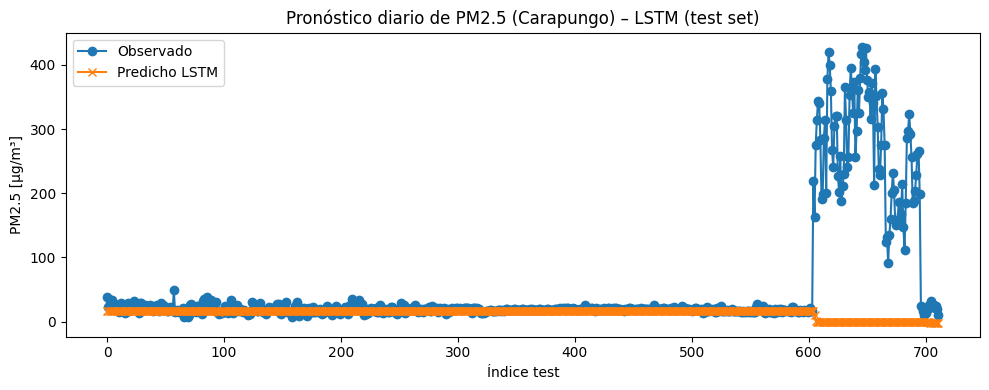

In [8]:
plt.figure(figsize=(10,4))
plt.plot(y_te, label="Observado", marker="o")
plt.plot(pred_lstm, label="Predicho LSTM", marker="x")
plt.title("Pronóstico diario de PM2.5 (Carapungo) – LSTM (test set)")
plt.ylabel("PM2.5 [µg/m³]")
plt.xlabel("Índice test")
plt.legend()
plt.tight_layout()
plt.show()


## 6. Comparative Evaluation and Discussion

- **SARIMAX** is useful for monthly trend forecasts, ideal for authorities and planning, but weak on extremes prediction.  
- **Random Forest** performs better at short horizon, useful for daily alerts, though it also smooths real variability.  
- **LSTM** likely requires more data and/or advanced tuning; not competitive in this case.  
- **Identified Limitations:**  
  - Historical missing data and potential measurement errors, especially in PM2.5 peaks.  
  - Models tend to be conservative towards rare outlier events.  
  - Only one station (Carapungo) was used for coverage and quality reasons, but method can be replicated to others.  
- **Recommendations:**  
  - Include external variables (e.g., traffic, fires, topography) for more robust hybrid models.  
  - Implement visualization and public consultation in a Streamlit app.  
  - Improve sensor infrastructure to reduce gaps and improve coverage.

In [9]:
pd.DataFrame({
    "Modelo": ["SARIMAX (mensual)", "RandomForest (diario)", "LSTM (diario)"],
    "Horizonte": ["mensual 2017", "últimos 10 días", "test 20%"],
    "RMSE": [rmse, rmse_rf, rmse_lstm],
    "MAE": [mae, mae_rf, mae_lstm]
})


,Modelo,Horizonte,RMSE,MAE
0,SARIMAX (mensual),mensual 2017,143.729999,78.195752
1,RandomForest (diario),últimos 10 días,4.168626,3.042214
2,LSTM (diario),test 20%,102.816845,38.752487


## 7. Applications, Implications, and Policy Proposals

- **Municipality:** Can use monthly forecasts for planning, alerts, and preventive policies.  
- **Citizens:** Early warnings can be issued when critical PM2.5 levels are forecasted.  
- **Public Health:** Forecasts enable preventive campaigns and resource prioritization.  
- **Future:** Replicate pipeline for all stations and expand variables to increase model robustness.


## 8. Key Visualizations

(Include in the PDF all your charts:  
- Missing values before/after  
- PM2.5 time series  
- Seasonal decomposition  
- Correlations  
- PCA and t-SNE  
- Prophet with changepoints  
- SARIMAX forecast  
- RF prediction last 10 days  
- RF forecast next 10 days  
- LSTM vs observed  
)



## 9. Conclusion

A complete data science pipeline was developed for PM2.5 forecasting in Quito using only the Carapungo station during 2008-2017, applying from cleaning and advanced imputation (SAITS) to statistical, machine learning, and deep learning models. The approach enabled comparing different methods and highlighted the importance of data quality and coverage for environmental forecasting models. The code and methodology can be reused and adapted for other stations or cities.


## 10. References

- SAITS: Wenjie Du et al., “SAITS: Self-attention-based Imputation for Time Series Data”, 2022.  
- Prophet: https://facebook.github.io/prophet/  
- Nixtla MLForecast: https://nixtlaverse.nixtla.io/mlforecast/index.html  
- Scikit-learn, statsmodels, pandas, missingno documentation.  
- Resources and papers on air quality modeling.  